In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


CSV_PATH = "train.csv"

store_id = 1
item_id = 1

L = 7

S = 100.0
z = 1.65
H = 2.0

MA_WINDOW = 14
ALPHA = 0.2


=== VISÃO GERAL DA BASE ===
Dimensão (linhas, colunas): (913000, 4)
Colunas: ['date', 'store', 'item', 'sales']

NAs por coluna:
 date     0
store    0
item     0
sales    0
dtype: int64

Duplicatas (date-store-item): 0


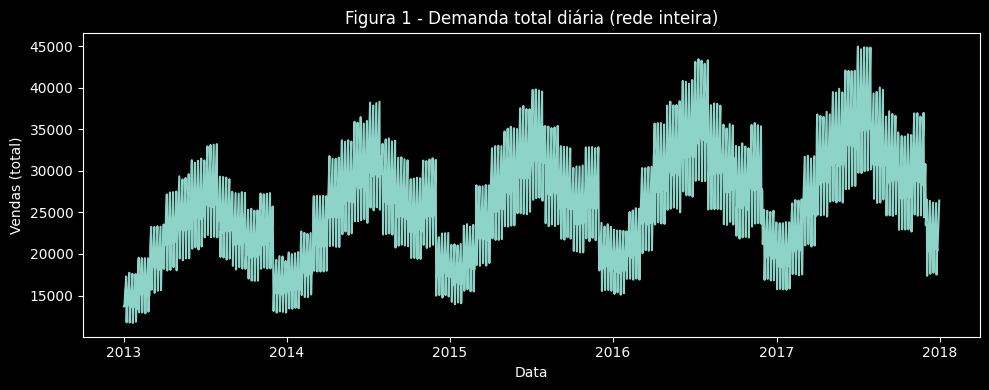

In [13]:
df = pd.read_csv(CSV_PATH)
df["date"] = pd.to_datetime(df["date"])

print("\n=== VISÃO GERAL DA BASE ===")
print("Dimensão (linhas, colunas):", df.shape)
print("Colunas:", df.columns.tolist())
print("\nNAs por coluna:\n", df.isna().sum())

dup = df.duplicated(subset=["date", "store", "item"]).sum()
print("\nDuplicatas (date-store-item):", dup)

daily_total = df.groupby("date")["sales"].sum().sort_index()

plt.figure(figsize=(10,4))
plt.plot(daily_total.index, daily_total.values)
plt.title("Figura 1 - Demanda total diária (rede inteira)")
plt.xlabel("Data")
plt.ylabel("Vendas (total)")
plt.tight_layout()
plt.show()


=== SÉRIE SELECIONADA (Loja 1, Item 1) ===
Período: 2013-01-01 -> 2017-12-31
Nº de dias: 1826

Estatísticas da demanda diária:
Média (mu_d): 19.9715
Desvio padrão (sigma_d): 6.741
P05: 10.0 | Mediana (P50): 19.0 | P95: 32.0
Mín: 4 | Máx: 50


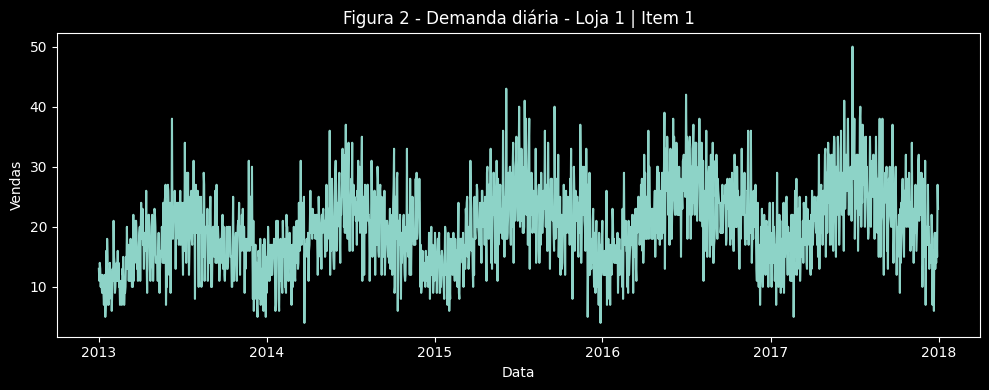

In [12]:
series = (
    df[(df["store"] == store_id) & (df["item"] == item_id)]
    .sort_values("date")
    .set_index("date")["sales"]
)

print("\n=== SÉRIE SELECIONADA (Loja {}, Item {}) ===".format(store_id, item_id))
print("Período:", series.index.min().date(), "->", series.index.max().date())
print("Nº de dias:", series.shape[0])

mu_d = float(series.mean())
sigma_d = float(series.std(ddof=1))
p05, p50, p95 = np.percentile(series.values, [5, 50, 95])

print("\nEstatísticas da demanda diária:")
print("Média (mu_d):", round(mu_d, 4))
print("Desvio padrão (sigma_d):", round(sigma_d, 4))
print("P05:", p05, "| Mediana (P50):", p50, "| P95:", p95)
print("Mín:", int(series.min()), "| Máx:", int(series.max()))

plt.figure(figsize=(10,4))
plt.plot(series.index, series.values)
plt.title(f"Figura 2 - Demanda diária - Loja {store_id} | Item {item_id}")
plt.xlabel("Data")
plt.ylabel("Vendas")
plt.tight_layout()
plt.show()

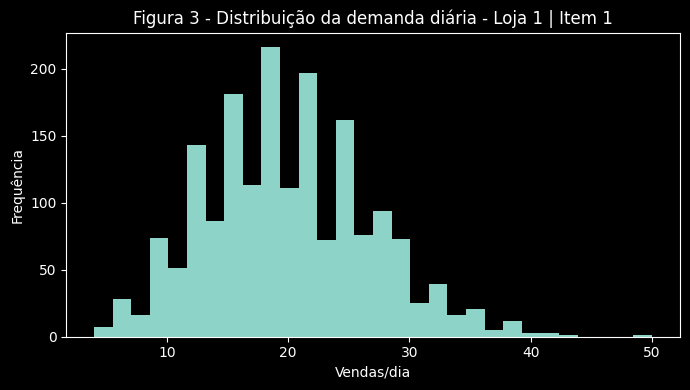

In [11]:
plt.figure(figsize=(7,4))
plt.hist(series.values, bins=30)
plt.title(f"Figura 3 - Distribuição da demanda diária - Loja {store_id} | Item {item_id}")
plt.xlabel("Vendas/dia")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

In [5]:
test_days = 60
train = series.iloc[:-test_days]
test = series.iloc[-test_days:]


ma_forecast = train.rolling(MA_WINDOW).mean()

ma_pred = []
hist = train.copy()
for t in range(len(test)):
    window = hist.iloc[-MA_WINDOW:]
    ma_pred.append(window.mean())
    hist = pd.concat([hist, pd.Series([test.iloc[t]], index=[test.index[t]])])
ma_pred = pd.Series(ma_pred, index=test.index)

level = train.iloc[0]
for x in train.iloc[1:]:
    level = ALPHA * x + (1 - ALPHA) * level

ses_pred = pd.Series([level]*len(test), index=test.index)

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))


=== PREVISÃO (baseline) - Avaliação no TESTE (últimos 60 dias) ===
MA (janela=14): MAE=4.625 | RMSE=5.949
SES (alpha=0.2): MAE=5.440 | RMSE=6.639


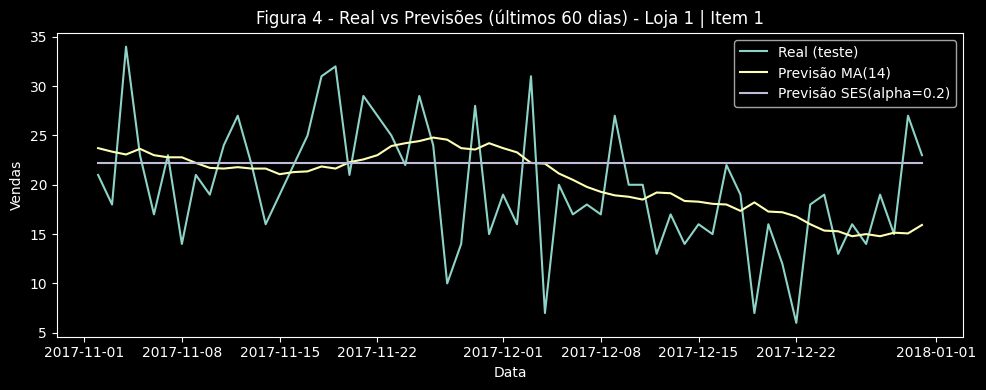

In [10]:
print("\n=== PREVISÃO (baseline) - Avaliação no TESTE (últimos {} dias) ===".format(test_days))
print("MA (janela={}): MAE={:.3f} | RMSE={:.3f}".format(MA_WINDOW, mae(test, ma_pred), rmse(test, ma_pred)))
print("SES (alpha={}): MAE={:.3f} | RMSE={:.3f}".format(ALPHA, mae(test, ses_pred), rmse(test, ses_pred)))


plt.figure(figsize=(10,4))
plt.plot(test.index, test.values, label="Real (teste)")
plt.plot(ma_pred.index, ma_pred.values, label=f"Previsão MA({MA_WINDOW})")
plt.plot(ses_pred.index, ses_pred.values, label=f"Previsão SES(alpha={ALPHA})")
plt.title(f"Figura 4 - Real vs Previsões (últimos {test_days} dias) - Loja {store_id} | Item {item_id}")
plt.xlabel("Data")
plt.ylabel("Vendas")
plt.legend()
plt.tight_layout()
plt.show()


=== MODELO DETERMINÍSTICO (EOQ) ===
Demanda anual estimada (D): 7289.61
S (custo por pedido): 100.0
H (custo anual de manutenção): 2.0
EOQ: 853.79

=== MODELO ESTOCÁSTICO (Q, R) ===
Lead time (L): 7 dias
Nível de serviço ~ z: 1.65
Demanda média no LT (mu_LT): 139.8
Desvio padrão no LT (sigma_LT): 17.84
Estoque de segurança (SS): 29.43
Ponto de pedido (R): 169.23


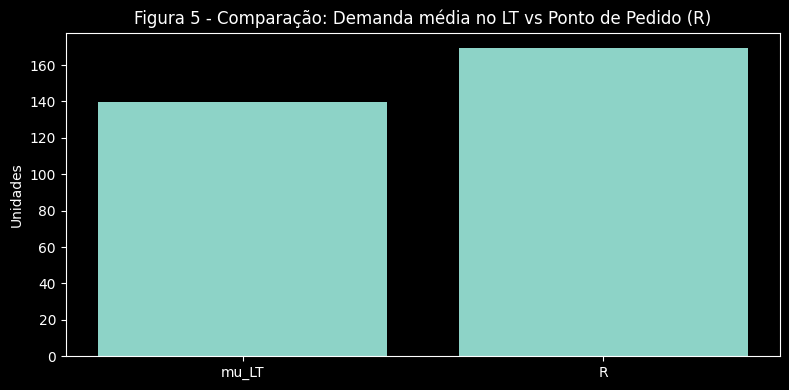

In [9]:
D = mu_d * 365.0

EOQ = np.sqrt((2.0 * D * S) / H)

print("\n=== MODELO DETERMINÍSTICO (EOQ) ===")
print("Demanda anual estimada (D):", round(D, 2))
print("S (custo por pedido):", S)
print("H (custo anual de manutenção):", H)
print("EOQ:", round(float(EOQ), 2))


mu_LT = mu_d * L
sigma_LT = sigma_d * np.sqrt(L)

SS = z * sigma_LT
R = mu_LT + SS

print("\n=== MODELO ESTOCÁSTICO (Q, R) ===")
print("Lead time (L):", L, "dias")
print("Nível de serviço ~ z:", z)
print("Demanda média no LT (mu_LT):", round(mu_LT, 2))
print("Desvio padrão no LT (sigma_LT):", round(sigma_LT, 2))
print("Estoque de segurança (SS):", round(SS, 2))
print("Ponto de pedido (R):", round(R, 2))


plt.figure(figsize=(8,4))
plt.bar(["mu_LT", "R"], [mu_LT, R])
plt.title("Figura 5 - Comparação: Demanda média no LT vs Ponto de Pedido (R)")
plt.ylabel("Unidades")
plt.tight_layout()
plt.show()

In [8]:
Q = max(1, int(round(EOQ)))

def simulate_qr(demand_series, Q, R, L):
    on_hand = float(R)
    pipeline = [0.0]*L
    stockouts = 0
    total_demand = 0.0
    filled = 0.0
    orders = 0

    for d in demand_series.values:

        arriving = pipeline.pop(0)
        on_hand += arriving
        pipeline.append(0.0)

        total_demand += d
        if on_hand >= d:
            on_hand -= d
            filled += d
        else:
            filled += on_hand
            on_hand = 0.0
            stockouts += 1

        inv_pos = on_hand + sum(pipeline)
        if inv_pos <= R:
            pipeline[-1] += Q
            orders += 1

    service_level_fillrate = filled / total_demand if total_demand > 0 else 0.0
    stockout_rate = stockouts / len(demand_series)

    return {
        "orders": orders,
        "fill_rate": service_level_fillrate,
        "stockout_rate_days": stockout_rate
    }

sim_results = simulate_qr(test, Q=Q, R=R, L=L)

print("\n=== SIMULAÇÃO (TÓPICO V - recomendado) ===")
print("Política simulada: Q =", Q, "| R =", round(R, 2), "| L =", L)
print("Nº de pedidos no período:", sim_results["orders"])
print("Fill rate (aprox.): {:.2%}".format(sim_results["fill_rate"]))
print("Taxa de dias com ruptura (aprox.): {:.2%}".format(sim_results["stockout_rate_days"]))


=== SIMULAÇÃO (TÓPICO V - recomendado) ===
Política simulada: Q = 854 | R = 169.23 | L = 7
Nº de pedidos no período: 2
Fill rate (aprox.): 100.00%
Taxa de dias com ruptura (aprox.): 0.00%
